In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    ]
)

dataset_full = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

full_loader = DataLoader(dataset=dataset_full, batch_size=8, shuffle=True)
subset_size = 2000
indices = np.random.choice(len(dataset_full), subset_size, replace=False)

# Create subset of the dataset
train_dataset = Subset(dataset_full, indices)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)


In [4]:
def show_images(original, reconstructed):
    original = original.detach().numpy()
    reconstructed = reconstructed.detach().numpy()

    plt.figure(figsize=(8, 4))
    for i in range(8):
        # Original images
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(original[i][0], cmap="gray")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, 8, i + 1 + 8)
        plt.imshow(reconstructed[i][0], cmap="gray")
        plt.axis("off")
    plt.show()

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=2, padding=1):
        super(ConvBlock, self).__init__()
        # (IC, H, W) -> (OC, (H + 2*padding - kernel_size)/stride, (H + 2*padding - kernel_size)/stride)
        self.layers =  nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),   
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.layers(x)
        return x

class ConvTBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        super(ConvTBlock, self).__init__()
        self.layers =  nn.Sequential(
            nn.ConvTranspose2d(
                input_channels,
                output_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=output_padding
            ),   
            nn.BatchNorm2d(output_channels),
        )
    def forward(self, x):
        x = self.layers(x)
        return x

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(32, 16),
            ConvBlock(16, 8),
            ConvBlock(8, 4),
            nn.Flatten(),
            nn.Linear(4 * 2 * 2, 4) 
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 4 * 2 * 2),
            Reshape(4, 2, 2),
            ConvTBlock(4, 8),
            ConvTBlock(8, 16,output_padding=0),
            nn.ReLU(),
            ConvTBlock(16, 32,),
            nn.ReLU(),
            ConvTBlock(32, 1,),
            nn.Tanh()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Calculate standard deviation
        eps = torch.randn_like(std)     # Sample epsilon from a normal distribution
        return mu + eps * std           # Reparameterize

    def forward(self, x):
        x = self.encoder(x)
        mu = x[:, :2]         # First part of the output is mu
        log_var = x[:, 2:]    # Second part of the output is log_var
        
        # Reparameterize to get the latent variable z
        z = self.reparameterize(mu, log_var)
        
        # Pass through decoder
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

In [6]:
model = ConvAutoencoder()
from torchinfo import summary
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                        Output Shape              Param #
ConvAutoencoder                               [8, 1, 28, 28]            --
├─Sequential: 1-1                             [8, 4]                    --
│    └─ConvBlock: 2-1                         [8, 32, 14, 14]           --
│    │    └─Sequential: 3-1                   [8, 32, 14, 14]           384
│    └─ConvBlock: 2-2                         [8, 16, 7, 7]             --
│    │    └─Sequential: 3-2                   [8, 16, 7, 7]             4,656
│    └─ConvBlock: 2-3                         [8, 8, 4, 4]              --
│    │    └─Sequential: 3-3                   [8, 8, 4, 4]              1,176
│    └─ConvBlock: 2-4                         [8, 4, 2, 2]              --
│    │    └─Sequential: 3-4                   [8, 4, 2, 2]              300
│    └─Flatten: 2-5                           [8, 16]                   --
│    └─Linear: 2-6                            [8, 4]                    68
├─Sequential

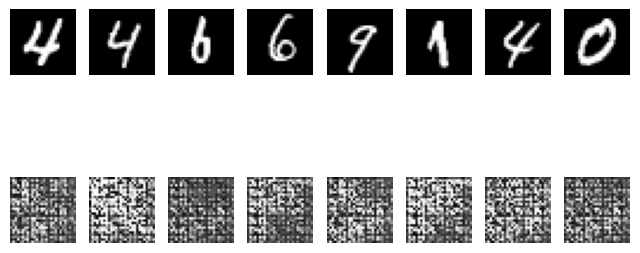

Initial loss: 7122.2168


In [7]:
test_images, _ = next(iter(train_loader))
with torch.no_grad():
    reconstructed_images, mus, stds  = model(test_images)

# Show original and reconstructed images
show_images(test_images, reconstructed_images)

def vae_loss(reconstructed, original, mu, log_var, beta = 0.1):
    # Binary cross-entropy reconstruction loss
    mse = nn.functional.mse_loss(reconstructed, original, reduction='sum')

    # KL divergence loss
    kl_div = -beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total VAE loss = Reconstruction loss + KL divergence loss
    return mse + kl_div

loss = 0
num = 0
for data in train_loader:
    images, _ = data

    outputs, mu, log_var = model(images)

    loss += vae_loss(outputs, images, mu, log_var)
    num += 1

print(f"Initial loss: {loss/num:.4f}")


In [8]:
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        img, _ = data

        # Forward pass
        output, mu, log_var = model(img)
        loss = vae_loss(output, img, mu, log_var)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 1553.4348
Epoch [2/20], Loss: 1377.7445
Epoch [3/20], Loss: 1233.1436
Epoch [4/20], Loss: 1514.6910
Epoch [5/20], Loss: 1360.8882
Epoch [6/20], Loss: 1217.5182
Epoch [7/20], Loss: 1041.9526
Epoch [8/20], Loss: 1577.0112
Epoch [9/20], Loss: 1158.5177
Epoch [10/20], Loss: 1663.2262
Epoch [11/20], Loss: 1327.8822
Epoch [12/20], Loss: 1367.9460
Epoch [13/20], Loss: 1258.3878
Epoch [14/20], Loss: 1306.1881
Epoch [15/20], Loss: 1298.9041
Epoch [16/20], Loss: 1768.2650
Epoch [17/20], Loss: 1521.7615
Epoch [18/20], Loss: 1285.1454
Epoch [19/20], Loss: 1386.0601
Epoch [20/20], Loss: 1198.0863


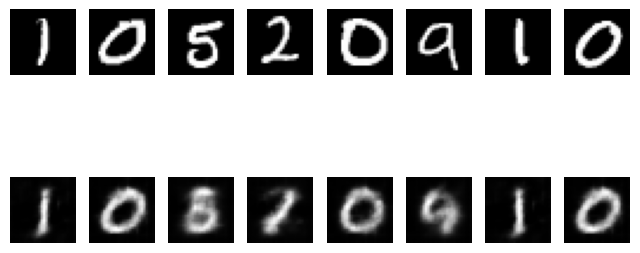

In [9]:
test_images, _ = next(iter(train_loader))
with torch.no_grad():
    reconstructed_images, mu, log_var = model(test_images)

# Show original and reconstructed images
show_images(test_images, reconstructed_images)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400


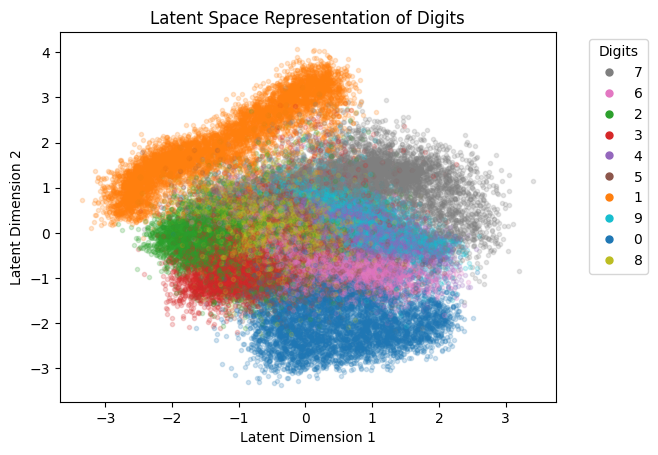

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

cmap = plt.get_cmap('tab10')  # 'tab10' provides 10 distinct colors

# Function to map numbers to colors
def number_to_color(num):
    assert 0 <= num <= 9, "Number must be between 0 and 9"
    return cmap(num / 9)  # Normalize the number to be between 0 and 1

# Create a list for the legend handles
legend_entries = {}

i = 0
with torch.no_grad():
    for batch, digits in full_loader:
        if not i % 100:
            print(i)
        i += 1
        latent_vecs = model.encoder(batch)
    
        for latent_vec, digit in zip(latent_vecs, digits):
            x, y = latent_vec.detach().numpy()[:2]  # Get the first two dimensions
            ax.plot(x, y, '.', color=number_to_color(digit), alpha=0.2)
            digit = digit.item()
    
            # Create a legend entry only if it hasn't been added yet
            if digit not in legend_entries:
                legend_entries[digit] = ax.plot([], [], '.', color=number_to_color(digit), label=str(digit), markersize=10)

# Create the legend
ax.legend(title="Digits", loc='upper right', bbox_to_anchor=(1.2, 1))

plt.title("Latent Space Representation of Digits")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.savefig("latent_representation")


In [11]:
next(iter(train_loader))[1][1].item()

9

In [12]:
latent_vectors = []
all_digits = []
all_images = []
with torch.no_grad():
    for batch in full_loader:
        images, digits = batch
        latent_vecs = model.encoder(images).detach().numpy()
        latent_vectors.append(latent_vecs)
        all_digits.append(digits.detach().numpy())
        all_images.append(images.detach().numpy())

latent_vectors = np.concatenate(latent_vectors, axis = 0)
digits = np.concatenate(all_digits, axis = 0)

In [13]:
mean = latent_vectors[:, :2]
std = latent_vectors[:, 2:]
images = np.concatenate(all_images, axis = 0)

In [14]:
mean.shape

(60000, 2)

In [15]:
digits.shape

(60000,)

In [16]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)

svm_clf.fit(mean[:20000], digits[:20000])

SVC(random_state=42)

In [17]:
svm_clf.predict(mean[20002].reshape(1, -1))

array([0])

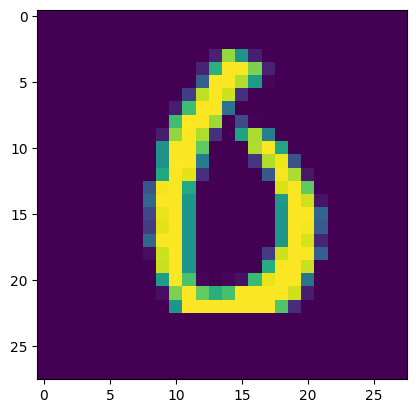

In [18]:
fig, ax = plt.subplots()
ax.imshow(images[20002][0])

In [19]:
predicted = svm_clf.predict(mean)

In [20]:
digits

array([1, 3, 2, ..., 0, 7, 9])

In [21]:
np.mean(digits == predicted)

0.6038

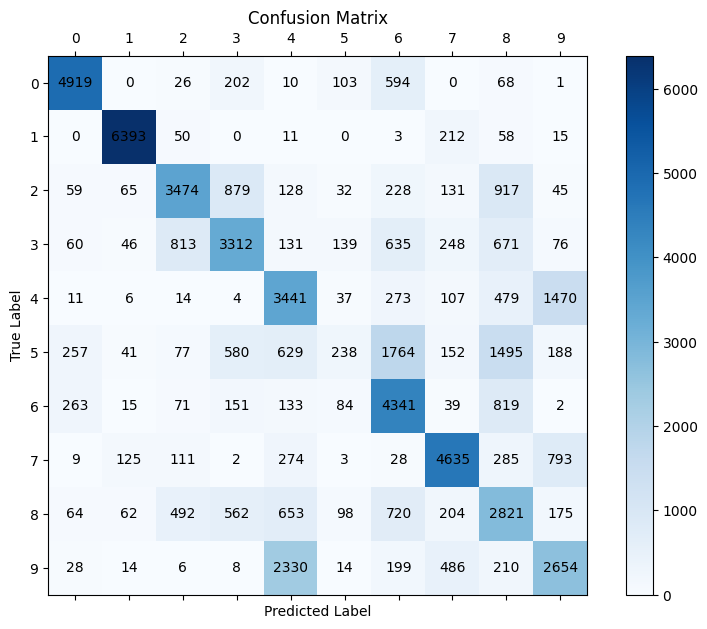

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

conf_matrix = confusion_matrix(digits, predicted)

fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(conf_matrix, cmap='Blues')  # Use 'Blues' colormap
fig.colorbar(cax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(10))

plt.show()
